In [1]:
from PIL import Image
import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
class CustomImageSegmentationMRF():
    """
    Start SA setting parameters

    Parameters
    ----------
    state :
        The current state to check with neighboring state for simulated annealing technique
    repeat_cnt:
        The number of times repeating move() until it reaches the convergence for simulated annealing technique
    t :
        Temperature
    t_ratio :
        Temperature ratio

    """

    def start(self, repeat_count, state, test_image_filepath, class_means, class_stds, fixed_pixel_indexes, beta=5,
              t=100, neighbor_count=4, t_ratio=0.97):
        self.t_ratio = t_ratio
        self.neighbor_count = neighbor_count
        self.fixed_pixel_indexes = fixed_pixel_indexes
        self.class_stds = class_stds
        self.class_means = class_means
        self.im = Image.open(test_image_filepath).convert('LA')
        self.pixels = self.im.load()
        self.beta = beta
        self.state = state
        self.e = self.get_total_energy()
        self.t = t
        self.move_count = 0
        for i in range(repeat_count):
            self.move()
            self.move_count += 1

        return self.state

    """
    Get the total energy of neighbors and intensity of each pixel 
    """

    def get_total_energy(self):
        e = 0
        self.j_max = len(self.state[0]) - 1
        self.i_max = len(self.state) - 1
        for i in range(len(self.state)):
            for j in range(len(self.state[0])):
                e += self.get_neighbors_sum_energy_for_total_energy_computing(i, j,
                                                                              self.neighbor_count) + self.get_pix_energy_just_for_intensity(
                    i, j)
        return e

    """
    Randomly move or alter the state
    """

    def move(self):
        if self.move_count % 300 == 0:
            self.t = self.t * self.t_ratio
        i = random.randint(0, len(self.state) - 1)
        j = random.randint(0, len(self.state[0]) - 1)
        while (i, j) in self.fixed_pixel_indexes:
            i = random.randint(0, len(self.state) - 1)
            j = random.randint(0, len(self.state[0]) - 1)

        rand_mean_index = random.randint(0, len(self.class_means) - 1)
        while (rand_mean_index == self.state[i][j]):
            rand_mean_index = random.randint(0, len(self.class_means) - 1)
        pre_state = self.state[i][j]
        new_e = self.e
        new_e -= self.get_pix_total_energy(i, j)
        self.state[i][j] = rand_mean_index
        new_e += self.get_pix_total_energy(i, j)
        if new_e < self.e:
            self.e = new_e
            return
        else:
            # self.state[i][j] = pre_state
            # return

            # if(new_e - self.e)<3:
            # if random.uniform(0, 1) <= self.t:
            if random.uniform(0, 1) <= np.math.exp(-1 * float(new_e - self.e) / float(self.t)):
                self.e = new_e
                return
            else:
                self.state[i][j] = pre_state
                return

    """
    Get the energy of the neighbors for each pixel and 
    return the sum of their energies multiplied by beta 
    in oder to calculate the doubletons 
    (Doubleton: favours similar labels at neighbouring pixels – smoothness prior)
    """

    def get_neighbors_sum_energy(self, i, j, neighbor_count):
        e = 0
        # This 4 conditions are in terms of showing the neighbors in 4 directions (up,down,left and right)
        if i != 0:
            e = e - 1 if self.state[i][j] == self.state[i - 1][j] else e + 1

        if j != 0:
            e = e - 1 if self.state[i][j] == self.state[i][j - 1] else e + 1

        if i != self.i_max:
            e = e - 1 if self.state[i][j] == self.state[i + 1][j] else e + 1

        if j != self.j_max:
            e = e - 1 if self.state[i][j] == self.state[i][j + 1] else e + 1

        # The next 4 conditions are used just in case of checking the rest of the neighbors (the diagonal ones)
        if neighbor_count == 8:
            if i != 0 and j != 0:
                e = e - 1 if self.state[i][j] == self.state[i - 1][j - 1] else e + 1

            if i != 0 and j != self.j_max:
                e = e - 1 if self.state[i][j] == self.state[i - 1][j + 1] else e + 1

            if i != self.i_max and j != 0:
                e = e - 1 if self.state[i][j] == self.state[i + 1][j - 1] else e + 1

            if i != self.i_max and j != self.j_max:
                e = e - 1 if self.state[i][j] == self.state[i + 1][j + 1] else e + 1

        return e * self.beta

    def get_neighbors_sum_energy_for_total_energy_computing(self, i, j, neighbor_count):
        e = 0
        if i != 0:
            e = e - 1 if self.state[i][j] == self.state[i - 1][j] else e + 1

        if j != 0:
            e = e - 1 if self.state[i][j] == self.state[i][j - 1] else e + 1

        if neighbor_count == 8:
            if i != 0 and j != 0:
                e = e - 1 if self.state[i][j] == self.state[i - 1][j - 1] else e + 1

            if i != 0 and j != self.j_max:
                e = e - 1 if self.state[i][j] == self.state[i - 1][j + 1] else e + 1

        return e * self.beta

    def get_pix_energy_just_for_intensity(self, i, j):
        class_std = self.class_stds[self.state[i][j]]
        class_mean = self.class_means[self.state[i][j]]
        pix = self.pixels[i, j][0]
        pix_e_change_for_intensity = np.math.log(get_pistd_term(class_std)) + get_exp_term(class_mean, class_std, pix)
        return pix_e_change_for_intensity

    def get_pix_total_energy(self, i, j):
        return self.get_pix_energy_just_for_intensity(i, j) + self.get_neighbors_sum_energy(i, j, self.neighbor_count)


In [3]:
def get_pistd_term(std):
    return float(np.math.sqrt(2 * np.math.pi * np.math.pow(std, 2)))

def get_exp_term(mean, std, val):
    return (float(np.math.pow(val - mean, 2)) / float(2 * np.math.pow(std, 2)))

def get_gaussian_naive_bayes_prob_per_class(mean, std, val):
    exp_term = get_exp_term(mean, std, val)
    pistd_term = get_pistd_term(std)
    return float(np.math.exp(-1 * exp_term)) / pistd_term

def segment_image(base_filepath,
                  test_image_filename, all_classes_image_per_label_pixels, class_means, class_stds):
    im = Image.open(base_filepath + test_image_filename).convert('LA')
    pixels = im.load()
    width, height = im.size
    # print(width, height)
    pixel_class_indexes = [[0 for x in range(height)] for y in range(width)]
    i = 0
    j = 0
    all_trues = 0
    all_pixels = 0
    while (i < width):
        while (j < height):
            all_pixels += 1
            pix = pixels[i, j][0]
            prob = -1
            is_true = False
            for idx, class_mean in enumerate(class_means):
                new_prob = get_gaussian_naive_bayes_prob_per_class(class_means[idx], class_stds[idx], pix)
                if new_prob > prob:
                    prob = new_prob
                    if (i, j) in all_classes_image_per_label_pixels[idx]:
                        is_true = True
                    else:
                        is_true = False
                        # print(i, j)
                    pixel_class_indexes[i][j] = idx

            if is_true:
                all_trues += 1
            j += 1
        i += 1
        j = 0
    return all_pixels, all_trues, pixel_class_indexes

In [4]:
def fit_normal_dist_per_class(original_image_filepath, train_image_filepath, other_pixels_color):
    image_per_label_pixels = set()
    orig_im = Image.open(original_image_filepath).convert('LA')
    orig_pixels = orig_im.load()
    width, height = orig_im.size
    i = 0
    j = 0
    while (i < width):
        while (j < height):
            pix = orig_pixels[i, j][0]
            if (pix != other_pixels_color):
                image_per_label_pixels.add((i, j))
            j += 1
        i += 1
        j = 0
    train_im = Image.open(train_image_filepath).convert('LA')
    train_pixels = train_im.load()
    data = [train_pixels[i, j][0] for (i, j) in image_per_label_pixels]
    mean, std = norm.fit(data)
    return mean, std, image_per_label_pixels

In [5]:
def fit_class_dists(class_original_image_filenames, noisy_train_image_filename, other_pixels_colors):
    class_means = []
    class_stds = []
    all_classes_image_per_label_pixels = []

    for class_original_image_filename, other_pixels_color in zip(class_original_image_filenames, other_pixels_colors):
        class_mean, class_std, class_image_per_label_pixels = fit_normal_dist_per_class(
            base_path + class_original_image_filename, base_path + noisy_train_image_filename, other_pixels_color)
        class_means.append(class_mean)
        class_stds.append(class_std)
        all_classes_image_per_label_pixels.append(class_image_per_label_pixels)
    return all_classes_image_per_label_pixels, class_means, class_stds

In [6]:
def report_segment_image_mrf(base_filepath,base_path_output, test_image_filename, labeled_image_filenme, noisy_train_image_filename,
                             class_original_image_filenames, other_pixels_colors, 
                             beta=5, t=100, neighbor_count=4,
                             true_label_prob=0, t_ratio=0.97):
    true_label_in_init_count = 0
    all_classes_image_per_label_pixels, class_means, class_stds = fit_class_dists(class_original_image_filenames,
                                                                                  noisy_train_image_filename,
                                                                                  other_pixels_colors)

    _, _, pixel_class_indexes = segment_image(base_filepath,
                                              test_image_filename, all_classes_image_per_label_pixels,
                                              class_means, class_stds)
    fixed_pixel_indexes = set()

    for i in range(len(pixel_class_indexes)):
        for j in range(len(pixel_class_indexes[0])):
            if random.uniform(0, 1) > true_label_prob:
                pixel_class_indexes[i][j] = random.randint(0, len(class_means) - 1)
            else:
                for idx, all_classes_image_per_label_pixel in enumerate(all_classes_image_per_label_pixels):
                    if (i, j) in all_classes_image_per_label_pixel:
                        pixel_class_indexes[i][j] = idx
                        true_label_in_init_count += 1
                        break

    image_segmentation_mrf = CustomImageSegmentationMRF()
    new_pixel_class_indexes = image_segmentation_mrf.start(500000, pixel_class_indexes,
                                                           base_path + test_image_filename, class_means, class_stds,
                                                           fixed_pixel_indexes, beta, t, neighbor_count, t_ratio)

    width = len(new_pixel_class_indexes)
    height = len(new_pixel_class_indexes[0])
    saving_im = Image.new('LA', (width, height))
    im = Image.open(base_filepath + test_image_filename).convert('LA')
    pixels = im.load()
    all_pixels_count = 0
    all_trues_count = 0
    for i in range(width):
        for j in range(height):
            saving_im.putpixel((i, j), (int(class_means[new_pixel_class_indexes[i][j]]), pixels[i, j][1]))
            all_pixels_count += 1
            if (i, j) in all_classes_image_per_label_pixels[new_pixel_class_indexes[i][j]]:
                all_trues_count += 1
    saving_im.save(base_path_output + labeled_image_filenme, 'png')
    print("accuracy: " + str(float(all_trues_count) / float(all_pixels_count)))
#     print("true_label_prob: " + str(true_label_prob))
#     print("true_label_in_init_count: " + str(true_label_in_init_count))
#     print("all_pixels_count: " + str(all_pixels_count))
    return float(all_trues_count) / float(all_pixels_count), saving_im, true_label_in_init_count

# ج، د.

In [20]:
base_path = "input/"
base_path_output = "output/"
class_original_image_filenames = ["test1-c1.png", "test1-c2.png", "test1-c3.png"]
other_pixels_colors = [0, 0, 255]
noisy_train_image_filename = "test1noisy0-01.bmp"

noises = ["01", "05", "09", "3"]
b = 1
neighbor_count = 4
true_label_prob = 0
t = 100
t_ratio = 0.97
accs = []
imgs = []

for noise in noises:
    labeled_image_filenme = "test1-labeled-mrf-" + noise + "-t" + str(t) + "-b" + str(
        b) + "-nc" + str(neighbor_count) + "-tp" + str(true_label_prob) + "-tr" + str(
        t_ratio) + ".png"
    print("result for : " + labeled_image_filenme)

    test_image_filename = "test1noisy0-" + noise + ".bmp"

    acc, img,_ = report_segment_image_mrf(base_path,base_path_output, test_image_filename, labeled_image_filenme,
                             noisy_train_image_filename,
                             class_original_image_filenames, other_pixels_colors, b, t,
                             neighbor_count, true_label_prob, t_ratio)
    accs.append(acc)
    imgs.append(img)

result for : test1-labeled-mrf-01-t100-b1-nc4-tp0-tr0.97.png
accuracy: 0.9968945528156055
result for : test1-labeled-mrf-05-t100-b1-nc4-tp0-tr0.97.png
accuracy: 0.9957903938167096
result for : test1-labeled-mrf-09-t100-b1-nc4-tp0-tr0.97.png
accuracy: 0.9934670592565329
result for : test1-labeled-mrf-3-t100-b1-nc4-tp0-tr0.97.png
accuracy: 0.8789795730585205


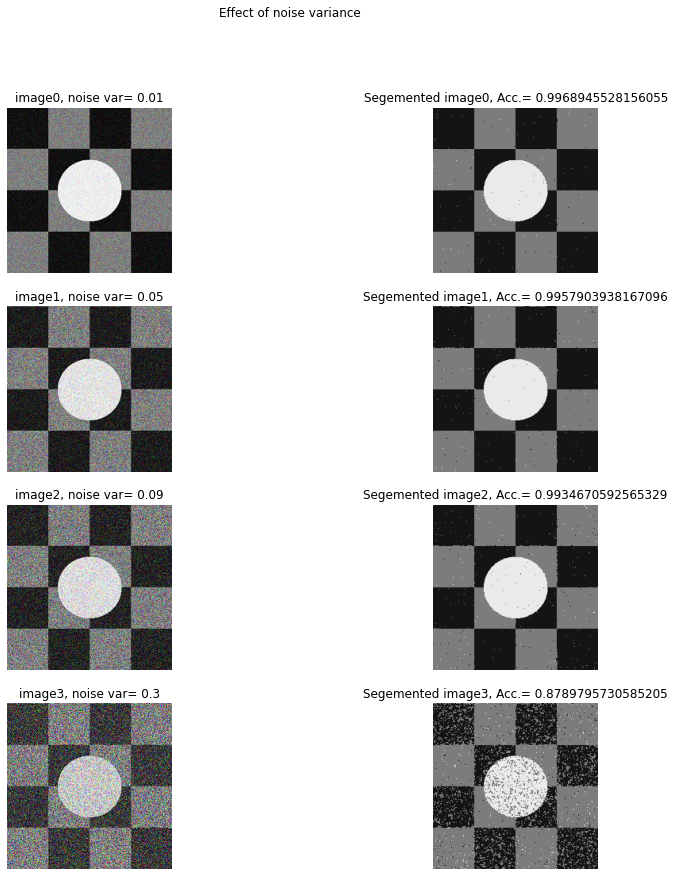

In [21]:
fig, axs = plt.subplots(4,2, figsize=(14,14))
fig.suptitle("Effect of noise variance")

for i in range(4):
    axs[i][0].imshow(mpimg.imread("input/test1noisy0-" + noises[i] + ".bmp"))
    axs[i][0].axis("off")
    axs[i][0].title.set_text('image'+str(i)+', noise var= 0.'+str(noises[i]))
    
    axs[i][1].imshow(imgs[i])
    axs[i][1].axis("off")
    axs[i][1].title.set_text('Segemented image'+str(i)+ ', Acc.= '+str(accs[i]))

# plt.tight_layout()
plt.show()

# ه.

In [9]:
base_path = "input/"
base_path_output = "output/"
class_original_image_filenames = ["test1-c1.png", "test1-c2.png", "test1-c3.png"]
other_pixels_colors = [0, 0, 255]
noisy_train_image_filename = "test1noisy0-01.bmp"

b = 1
true_label_prob = 0
t = 100
t_ratio = 0.97

noises = ["05", "09", "3"]
neighbor_counts = [4,8]
accs = []
imgs = []

for noise in noises:
    accs_temp = []
    imgs_temp = []
    for neighbor_count in neighbor_counts:
        labeled_image_filenme = "test1-labeled-mrf-" + noise + "-t" + str(t) + "-b" + str(
            b) + "-nc" + str(neighbor_count) + "-tp" + str(true_label_prob) + "-tr" + str(
            t_ratio) + ".png"
        print("result for : " + labeled_image_filenme)
        test_image_filename = "test1noisy0-" + noise + ".bmp"
        acc, img, _ = report_segment_image_mrf(base_path,base_path_output, test_image_filename, labeled_image_filenme,
                             noisy_train_image_filename,
                             class_original_image_filenames, other_pixels_colors, b, t,
                             neighbor_count, true_label_prob, t_ratio)
        accs_temp.append(acc)
        imgs_temp.append(img) 
    accs.append(accs_temp)
    imgs.append(imgs_temp)

result for : test1-labeled-mrf-05-t100-b1-nc4-tp0-tr0.97.png
accuracy: 0.9960664335664335
result for : test1-labeled-mrf-05-t100-b1-nc8-tp0-tr0.97.png
accuracy: 0.9970785793154214
result for : test1-labeled-mrf-09-t100-b1-nc4-tp0-tr0.97.png
accuracy: 0.99326002944424
result for : test1-labeled-mrf-09-t100-b1-nc8-tp0-tr0.97.png
accuracy: 0.9959744203165256
result for : test1-labeled-mrf-3-t100-b1-nc4-tp0-tr0.97.png
accuracy: 0.8766102318733898
result for : test1-labeled-mrf-3-t100-b1-nc8-tp0-tr0.97.png
accuracy: 0.9319101950680898


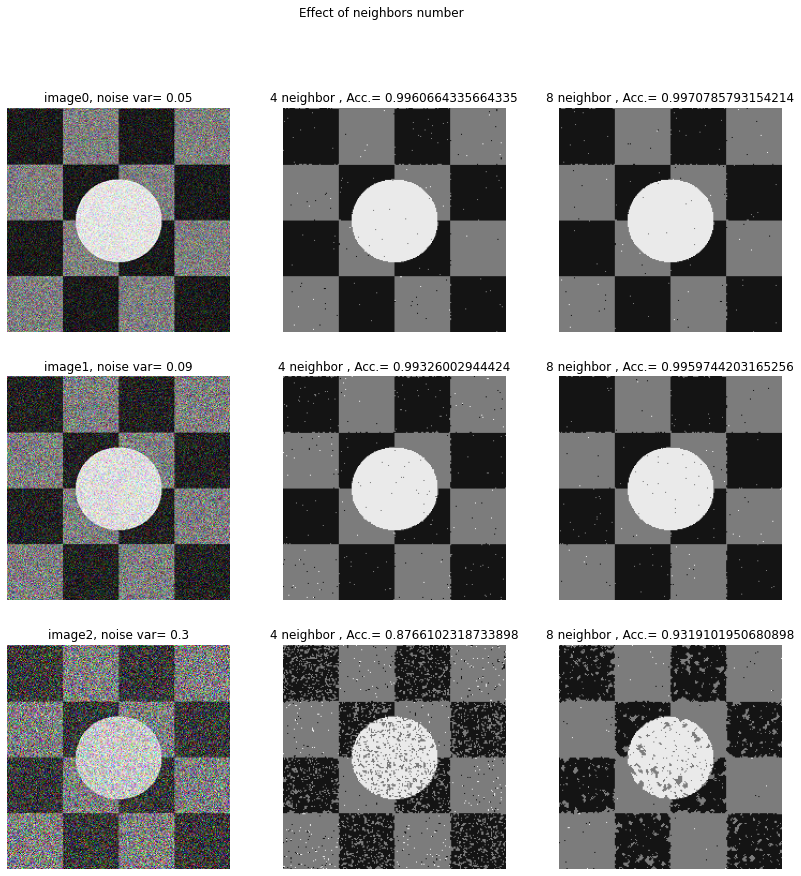

In [10]:
neighbor_number = len(neighbor_counts)
fig, axs = plt.subplots(3,neighbor_number+1, figsize=(14,14))
fig.suptitle("Effect of neighbors number")

for i in range(3):
    axs[i][0].imshow(mpimg.imread("input/test1noisy0-" + noises[i] + ".bmp"))
    axs[i][0].axis("off")
    axs[i][0].title.set_text('image'+str(i)+', noise var= 0.'+str(noises[i]))
    
    for j in range(neighbor_number):
        axs[i][j+1].imshow(imgs[i][j])
        axs[i][j+1].axis("off")
        axs[i][j+1].title.set_text(str(neighbor_counts[j])+' neighbor , Acc.= '+str(accs[i][j]))

# plt.tight_layout()
plt.show()

# و.

In [11]:
base_path = "input/"
base_path_output = "output/"
class_original_image_filenames = ["test1-c1.png", "test1-c2.png", "test1-c3.png"]
other_pixels_colors = [0, 0, 255]
noisy_train_image_filename = "test1noisy0-01.bmp"

neighbor_count = 4
bs = [0.1, 0.5, 1, 5, 7, 10, 15]
true_label_prob = 0
t = 100
t_ratio = 0.97

noise = "3"
# noises = ["05", "09", "3"]
accs = []
imgs = []

for b in bs:
    labeled_image_filenme = "test1-labeled-mrf-" + noise + "-t" + str(t) + "-b" + str(
        b) + "-nc" + str(neighbor_count) + "-tp" + str(true_label_prob) + "-tr" + str(
        t_ratio) + ".png"
    print("result for : " + labeled_image_filenme)
    test_image_filename = "test1noisy0-" + noise + ".bmp"
    acc, img, _ = report_segment_image_mrf(base_path,base_path_output, test_image_filename, labeled_image_filenme,
                         noisy_train_image_filename,
                         class_original_image_filenames, other_pixels_colors, b, t,
                         neighbor_count, true_label_prob, t_ratio)
    accs.append(acc)
    imgs.append(img)

result for : test1-labeled-mrf-3-t100-b0.1-nc4-tp0-tr0.97.png
accuracy: 0.7748665807876334
result for : test1-labeled-mrf-3-t100-b0.5-nc4-tp0-tr0.97.png
accuracy: 0.8302355539197644
result for : test1-labeled-mrf-3-t100-b1-nc4-tp0-tr0.97.png
accuracy: 0.8802907618697092
result for : test1-labeled-mrf-3-t100-b5-nc4-tp0-tr0.97.png
accuracy: 0.826486013986014
result for : test1-labeled-mrf-3-t100-b7-nc4-tp0-tr0.97.png
accuracy: 0.826048951048951
result for : test1-labeled-mrf-3-t100-b10-nc4-tp0-tr0.97.png
accuracy: 0.7932462274567538
result for : test1-labeled-mrf-3-t100-b15-nc4-tp0-tr0.97.png
accuracy: 0.763663967611336


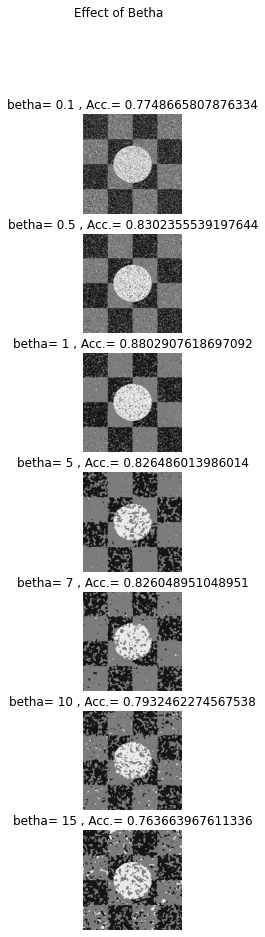

In [12]:
fig, axs = plt.subplots(7,1, figsize=(15,15))
fig.suptitle("Effect of Betha")

for i in range(7):    
    axs[i].imshow(imgs[i])
    axs[i].axis("off")
    axs[i].title.set_text('betha= '+str(bs[i])+ ' , Acc.= '+str(accs[i]))

# plt.tight_layout()
plt.show()

# ز.

In [13]:
base_path = "input/"
base_path_output = "output/"
class_original_image_filenames = ["test1-c1.png", "test1-c2.png", "test1-c3.png"]
other_pixels_colors = [0, 0, 255]
noisy_train_image_filename = "test1noisy0-01.bmp"

neighbor_count = 4
b = 1
true_label_probs = [0.3,0.5, 0.7, 0.9]
t = 100
t_ratio = 0.97

noise = "3"
accs = []
imgs = []
true_label_in_init_counts = []
for true_label_prob in true_label_probs:
    labeled_image_filenme = "test1-labeled-mrf-" + noise + "-t" + str(t) + "-b" + str(
        b) + "-nc" + str(neighbor_count) + "-tp" + str(true_label_prob) + "-tr" + str(
        t_ratio) + ".png"
    print("result for : " + labeled_image_filenme)
    test_image_filename = "test1noisy0-" + noise + ".bmp"
    acc, img, true_label_in_init_count = report_segment_image_mrf(base_path,base_path_output, test_image_filename, labeled_image_filenme,
                         noisy_train_image_filename,
                         class_original_image_filenames, other_pixels_colors, b, t,
                         neighbor_count, true_label_prob, t_ratio)
    accs.append(acc)
    imgs.append(img)
    true_label_in_init_counts.append(true_label_in_init_count)

result for : test1-labeled-mrf-3-t100-b1-nc4-tp0.3-tr0.97.png
accuracy: 0.888433934486566
result for : test1-labeled-mrf-3-t100-b1-nc4-tp0.5-tr0.97.png
accuracy: 0.8946678321678322
result for : test1-labeled-mrf-3-t100-b1-nc4-tp0.7-tr0.97.png
accuracy: 0.8992454913507545
result for : test1-labeled-mrf-3-t100-b1-nc4-tp0.9-tr0.97.png
accuracy: 0.9051573426573427


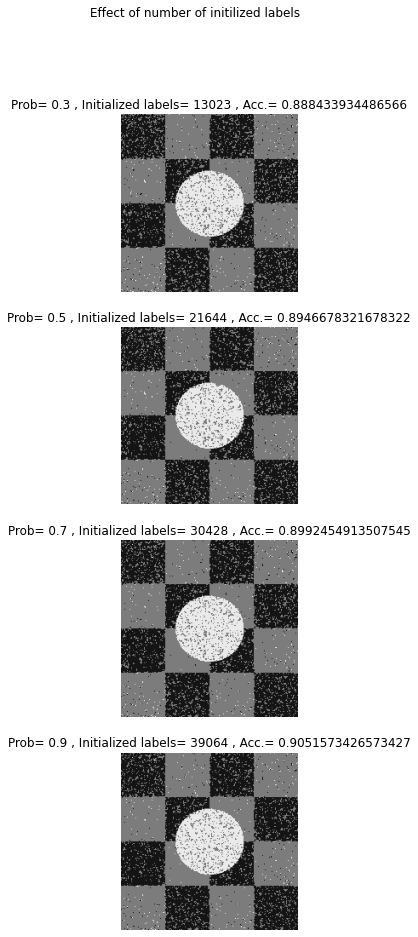

In [14]:
fig, axs = plt.subplots(4,1, figsize=(15,15))
fig.suptitle("Effect of number of initilized labels")

for i in range(4):
    axs[i].imshow(imgs[i])
    axs[i].axis("off")
    axs[i].title.set_text('Prob= '+str(true_label_probs[i])+' , Initialized labels= '
                          +str(true_label_in_init_counts[i])+ ' , Acc.= '+str(accs[i]))


# fig.tight_layout()
plt.show()

# ح.

In [15]:
base_path = "input/"
base_path_output = "output/"
class_original_image_filenames = ["test1-c1.png", "test1-c2.png", "test1-c3.png"]
other_pixels_colors = [0, 0, 255]
noisy_train_image_filename = "test1noisy0-01.bmp"

neighbor_count = 4
b = 1
true_label_prob = 0
ts = [0.0001, 10, 100, 1000, 1000000000]
t_ratio = 0.97

noise = "3"
accs = []
imgs = []
for t in ts:
    labeled_image_filenme = "test1-labeled-mrf-" + noise + "-t" + str(t) + "-b" + str(
        b) + "-nc" + str(neighbor_count) + "-tp" + str(true_label_prob) + "-tr" + str(
        t_ratio) + ".png"
    print("result for : " + labeled_image_filenme)
    test_image_filename = "test1noisy0-" + noise + ".bmp"
    acc, img, _ = report_segment_image_mrf(base_path,base_path_output, test_image_filename, labeled_image_filenme,
                         noisy_train_image_filename,
                         class_original_image_filenames, other_pixels_colors, b, t,
                         neighbor_count, true_label_prob, t_ratio)
    accs.append(acc)
    imgs.append(img)

result for : test1-labeled-mrf-3-t0.0001-b1-nc4-tp0-tr0.97.png
accuracy: 0.881762973868237
result for : test1-labeled-mrf-3-t10-b1-nc4-tp0-tr0.97.png
accuracy: 0.8799457121825542
result for : test1-labeled-mrf-3-t100-b1-nc4-tp0-tr0.97.png
accuracy: 0.8803827751196173
result for : test1-labeled-mrf-3-t1000-b1-nc4-tp0-tr0.97.png
accuracy: 0.8773923444976076
result for : test1-labeled-mrf-3-t1000000000-b1-nc4-tp0-tr0.97.png
accuracy: 0.8555622009569378


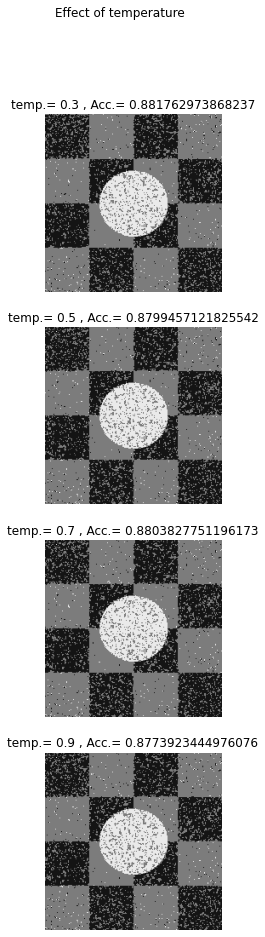

In [16]:
fig, axs = plt.subplots(4,1, figsize=(15,15))
fig.suptitle("Effect of temperature")

for i in range(4):
    axs[i].imshow(imgs[i])
    axs[i].axis("off")
    axs[i].title.set_text('temp.= '+str(true_label_probs[i])+ ' , Acc.= '+str(accs[i]))

plt.show()

In [17]:
base_path = "input/"
base_path_output = "output/"
class_original_image_filenames = ["test1-c1.png", "test1-c2.png", "test1-c3.png"]
other_pixels_colors = [0, 0, 255]
noisy_train_image_filename = "test1noisy0-01.bmp"

neighbor_count = 4
b = 1
true_label_prob = 0
t = 100
t_ratios = [0.55, 0.75, 0.97, 1]

noise = "3"
accs = []
imgs = []
for t_ratio in t_ratios:
    labeled_image_filenme = "test1-labeled-mrf-" + noise + "-t" + str(t) + "-b" + str(
        b) + "-nc" + str(neighbor_count) + "-tp" + str(true_label_prob) + "-tr" + str(
        t_ratio) + ".png"
    print("result for : " + labeled_image_filenme)
    test_image_filename = "test1noisy0-" + noise + ".bmp"
    acc, img, _ = report_segment_image_mrf(base_path,base_path_output, test_image_filename, labeled_image_filenme,
                         noisy_train_image_filename,
                         class_original_image_filenames, other_pixels_colors, b, t,
                         neighbor_count, true_label_prob, t_ratio)
    accs.append(acc)
    imgs.append(img)

result for : test1-labeled-mrf-3-t100-b1-nc4-tp0-tr0.55.png
accuracy: 0.8777373941847626
result for : test1-labeled-mrf-3-t100-b1-nc4-tp0-tr0.75.png
accuracy: 0.8782204637467795
result for : test1-labeled-mrf-3-t100-b1-nc4-tp0-tr0.97.png
accuracy: 0.8782204637467795
result for : test1-labeled-mrf-3-t100-b1-nc4-tp0-tr1.png
accuracy: 0.3810498711814501


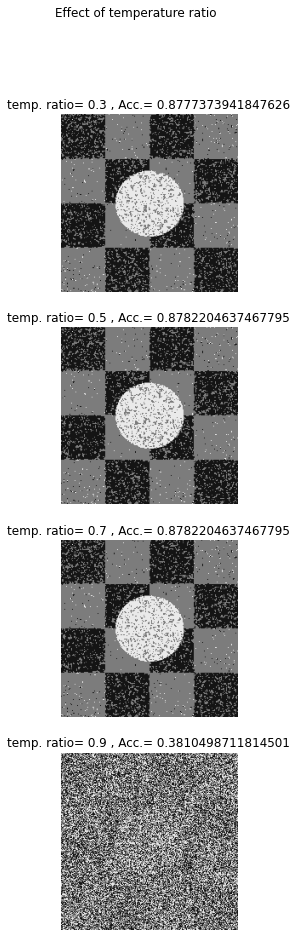

In [18]:
fig, axs = plt.subplots(4,1, figsize=(15,15))
fig.suptitle("Effect of temperature ratio")

for i in range(4):
    axs[i].imshow(imgs[i])
    axs[i].axis("off")
    axs[i].title.set_text('temp. ratio= '+str(true_label_probs[i])+ ' , Acc.= '+str(accs[i]))

plt.show()